In this file, X is corelated. We set the initial batch very small, where the baseline algorithm is no longer applicable.

In [1]:
import numpy as np
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import math
import scipy
import matplotlib.pyplot as plt
from scipy.stats import t


In [2]:
def MSE(x1,x2):
    return np.sum((x1-x2)**2)

In [3]:
np.random.seed(1)

p = 1000
T = 30000
t0= [50,100,150,200,250,300,400,500]

Cov = np.zeros((p,p))
rho = 0.5
for i in range(p):
    for j in range(p):
        Cov[i,j] = rho**abs(i-j)
    Cov[i,i]= 1
sigma = 1
Cov = Cov*sigma
eigs,_ = np.linalg.eig(Cov)
print('The minimum eig value is %f'%np.min(eigs))
mu = np.zeros(p)

The minimum eig value is 0.333334


In [4]:
theta_true = 0.5*scipy.sparse.random(p, 1, density=0.02,random_state=np.random.default_rng()).A.reshape(p)
X0_data = np.random.multivariate_normal(mu,Cov,500).T
y0_data = X0_data.T.dot(theta_true) + np.random.normal(0,1,500)


X_data = np.random.multivariate_normal(mu,Cov,T).T
y_data = X_data.T.dot(theta_true) + np.random.normal(0,1,T)

theta_init = np.random.normal(0, 0.5, p)

eta=0.001
K=20

In [5]:
def Lasso_SSR(t0,XX0,XY0,XX,XY,theta,num,step,epsilon=1e-7):
    grad_now=(XX@theta-XY)/num
    grad_init=(XX0@theta-XY0)/t0
    phi=grad_now -grad_init
    lam=math.sqrt(math.log(p)/num)
    loss=0xFFFF
    #print(lam)
    while loss>=epsilon:
        theta_p=theta
        tmp=theta-step*((XX0@theta-XY0)/t0+phi).T
        theta=np.sign(tmp)*np.maximum(abs(tmp)-lam*step,0)
        loss=np.sum((theta-theta_p)**2)
    return theta

In [6]:
def Lasso_IHT(XX,XY,num,theta,idx,eta): 
    theta  = theta  - eta*(XX@theta - XY)/num
    temp = np.zeros(p)
    temp[idx] = theta[idx]  
    return temp

In [7]:
def test_data_size(S,t0,step):
    error_SSR,error_OS,error_OSK=[],[],[]
    stmp=[]
    X0=X0_data[:,0:t0+1]
    y0=y0_data[0:t0+1]
    XX0=X0@X0.T
    XY0=X0@y0
    XX=np.zeros((p,p))
    XY=np.zeros(p)
    theta_LASSO= np.zeros(p)
    a,b=np.linalg.eig(XX0)
    step=step*t0/np.max(a.real)
    for i in range(T):
        num=i+1
        x=X_data[:,i]
        y=y_data[i]
        XX = XX + np.outer(x,x.T)
        XY = XY + x*y
        if i >= S:
            theta_LASSO=Lasso_SSR(100,XX0,XY0,XX,XY,theta_LASSO,num,step)
        if (i+1)%(T/300)==0:
            #print("progress rate: {}% ...".format((i+1)/(T/300)))
            error_SSR.append(theta_LASSO)
    return error_SSR

In [8]:
Error_SSR=test_data_size(30,10,0.02)

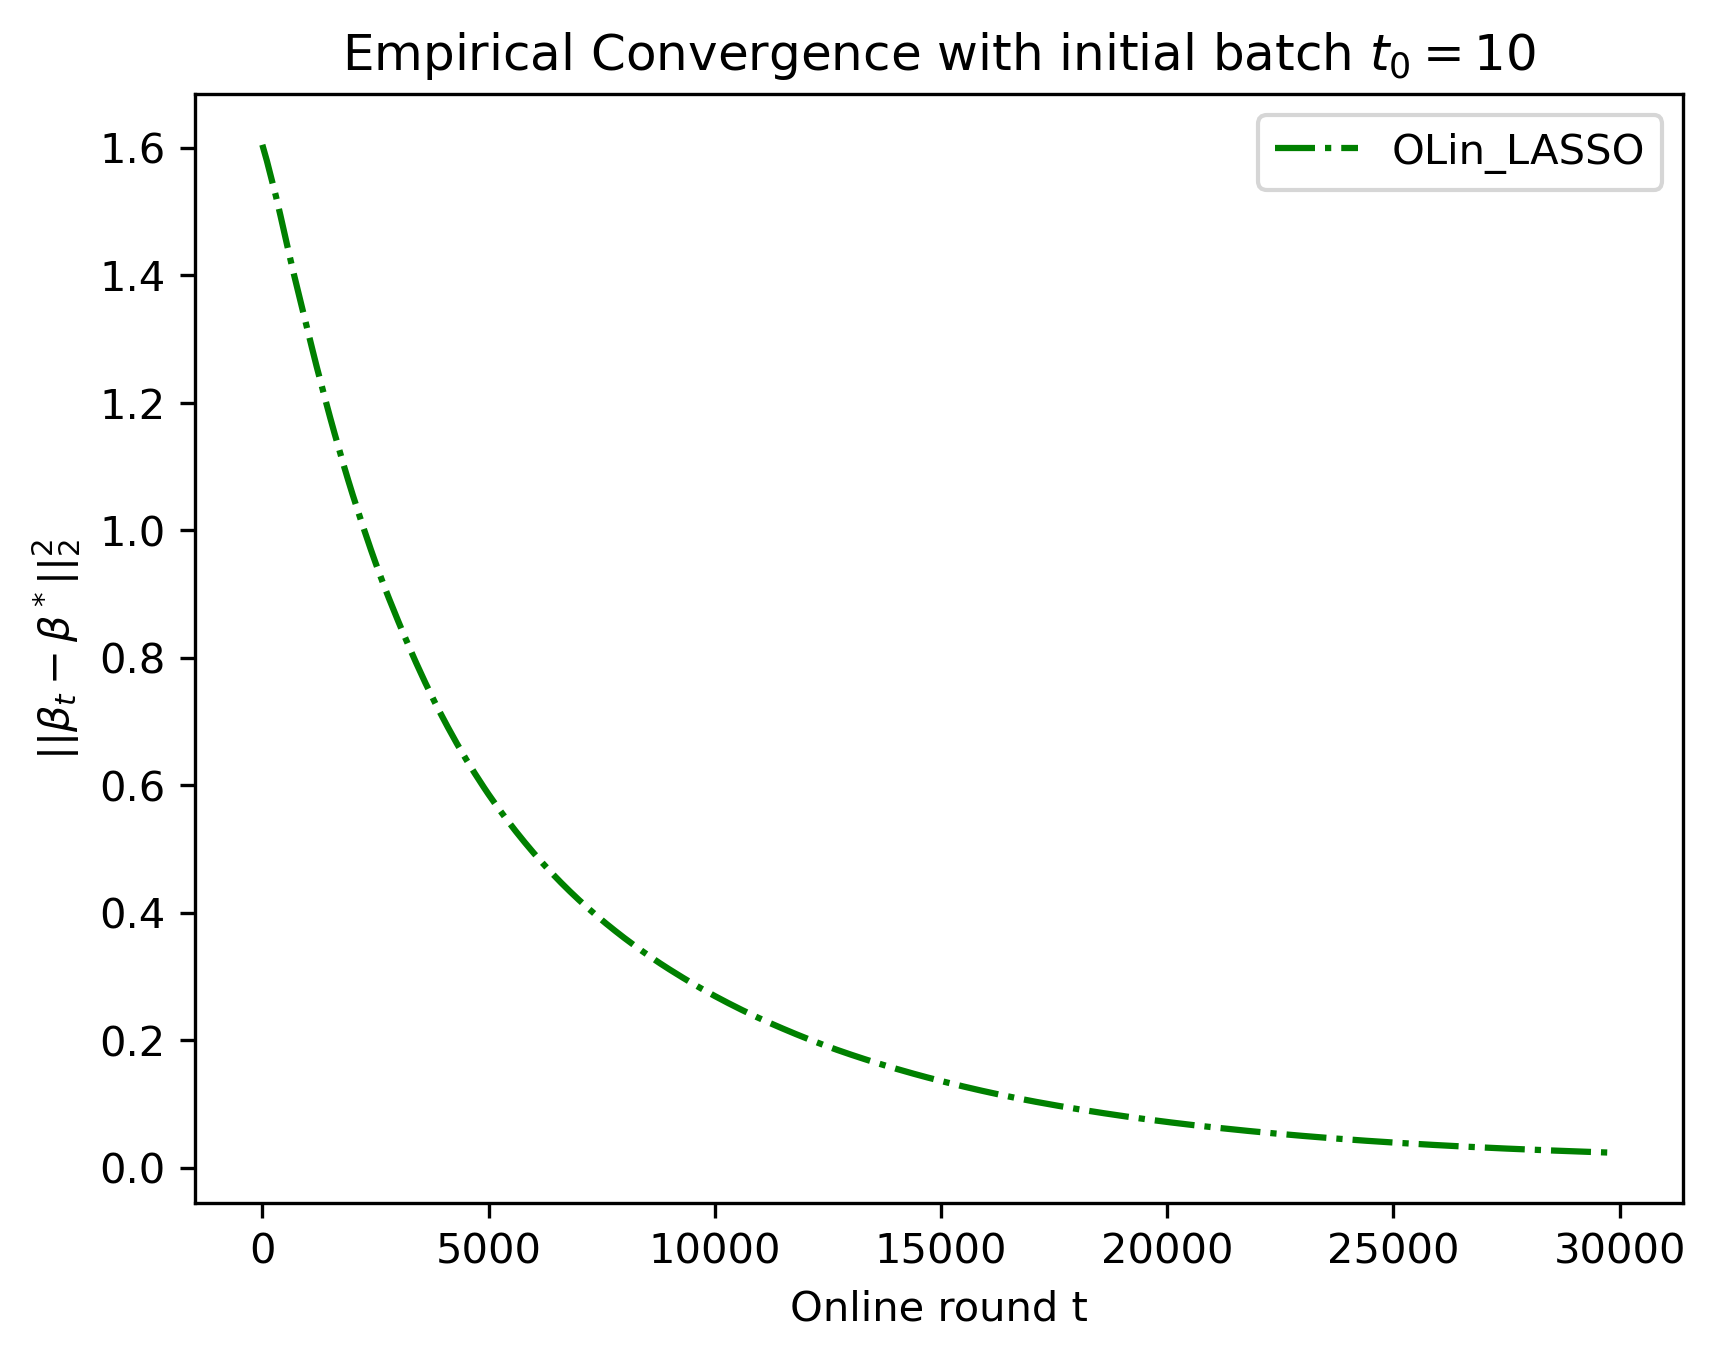

In [9]:
xline=np.array([i*100 for i in range(len(Error_SSR))])
y2line=np.array([MSE(Error_SSR[i],theta_true) for i in range(len(Error_SSR))])
plt.figure(dpi=300)
plt.plot(xline,y2line,label = "OLin_LASSO", linestyle="-.",color='g')
plt.xlabel('Online round t')
plt.ylabel('$|| \\beta_t - \\beta^*||^2_2$')
plt.title('Empirical Convergence with initial batch $t_0 = 10$')
plt.legend()
plt.show()

In [10]:
error_SSR=test_data_size(30,1,0.15)

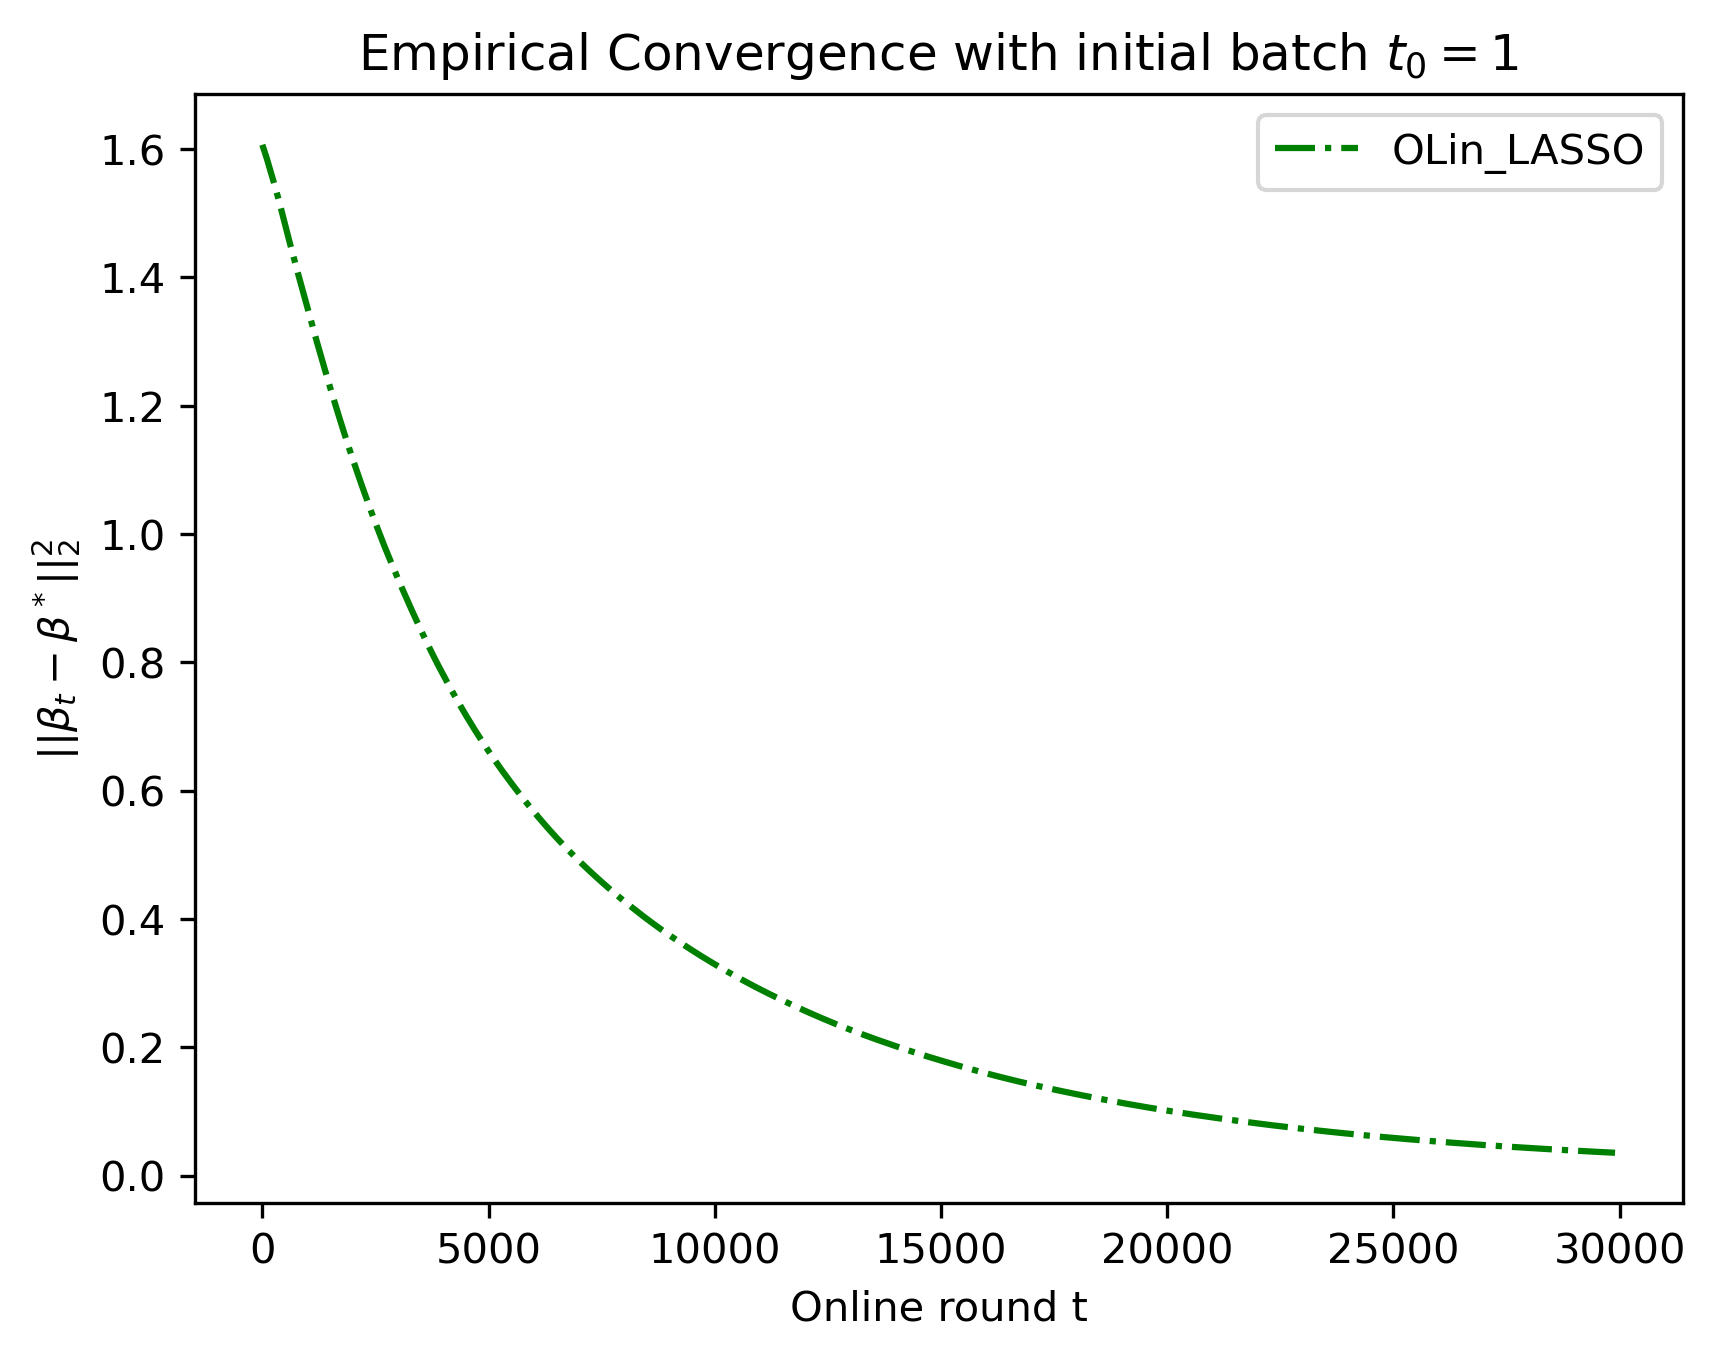

In [11]:
xline=np.array([i*100 for i in range(len(error_SSR))])
y1line=np.array([MSE(error_SSR[i],theta_true) for i in range(len(error_SSR))])
plt.figure(dpi=300)
plt.plot(xline,y1line,label = "OLin_LASSO", linestyle="-.",color='g')
plt.xlabel('Online round t')
plt.ylabel('$|| \\beta_t - \\beta^*||^2_2$')
#plt.ylim((0,0.5))
plt.title('Empirical Convergence with initial batch $t_0 = 1$')
#plt.ylim((0,0.5))
plt.legend()
plt.show()